In [1]:
pip install photutils

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for photutils from https://files.pythonhosted.org/packages/92/79/47e460f8f0015a7c8fca825641a24362b147c128e08f1bfa3ee39eac8f6f/photutils-1.10.0-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import glob
import os
from astropy.io.fits import getheader
from astropy.io.fits import getdata
from sys import getsizeof
import matplotlib as mpl
from itertools import product
from photutils.centroids import centroid_2dg
from photutils.aperture import CircularAperture
import math
%matplotlib inline

In [2]:
centered_stars = getdata('center_box.fits')
centered_stars = centered_stars-835

In [3]:
low  = np.percentile(centered_stars, 20) 
high = np.percentile(centered_stars, 94)

In [4]:
center_x = 20
center_y = 20
outer_annulus = 19

In [10]:
plot_y_len = len(centered_stars[0,:,0])
plot_x_len = len(centered_stars[0,0,:])

def star_flux(xcen, ycen, image, star_radius): #image is 2d array
    aperture_vals = np.array([])
    annulus_vals = np.array([])
    
    for y,x in product(range(0,plot_y_len), range(0, plot_x_len)):
    #find the value of each pixel inside the aperture
        if (np.sqrt((x-xcen)**2 + (y-ycen)**2)) <= star_radius:
            aperture_vals = np.append(aperture_vals, image[y,x])
    #find the value of each pixel inside the ring
        if (np.sqrt((x-xcen)**2 + (y-ycen)**2)) <= outer_annulus:
            annulus_vals = np.append(annulus_vals, image[y,x])
    #compute the flux by subtracting the background value in the annulus       
        annulus_median = np.median(annulus_vals)
        flux_no_background = aperture_vals - annulus_median
        total_flux = 1.6 * np.sum(flux_no_background)
    return total_flux, aperture_vals, annulus_vals

def std_star_flux(xcen, ycen, image, star_radius): #image is 2d array
    aperture_vals = np.array([])
    annulus_vals = np.array([])
    
    for y,x in product(range(0,plot_y_len), range(0, plot_x_len)):
    #find the value of each pixel inside the aperture
        if (np.sqrt((x-xcen)**2 + (y-ycen)**2)) <= star_radius:
            aperture_vals = np.append(aperture_vals, image[y,x])
    #find the value of each pixel inside the ring
        if (np.sqrt((x-xcen)**2 + (y-ycen)**2)) <= outer_annulus:
            annulus_vals = np.append(annulus_vals, image[y,x])
    #compute the flux by subtracting the background value in the annulus       
        annulus_median = np.median(annulus_vals)
        flux_noise = aperture_vals + annulus_median
        total_std = np.sqrt(1.6) * np.sqrt(np.sum(flux_noise))
    return total_std

/tmp/ipykernel_1440312/1228327621.py:35: RuntimeWarning: invalid value encountered in sqrt
  total_std = np.sqrt(1.6) * np.sqrt(np.sum(flux_noise))


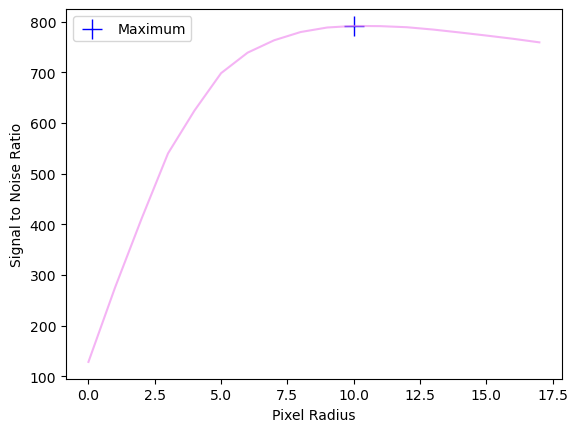

In [8]:
x = np.arange(0,18)

signal_radius = []

for i in np.arange(0,18):
    signal_radius = np.append(signal_radius, star_flux(center_x, center_y, centered_stars[1],i)[0]/std_star_flux(center_x, center_y, centered_stars[1],i)[0])

plt.plot(x,signal_radius, color = 'violet', alpha = 0.6)
plt.scatter(10,791, s= 200, marker = "+", lw = 1, color = "blue", label = "Maximum")
plt.legend()
plt.xlabel("Pixel Radius")
plt.ylabel("Signal to Noise Ratio")
plt.savefig("SignaltoNoise.png")

In [7]:
np.max(signal_radius)

791.8216632209102

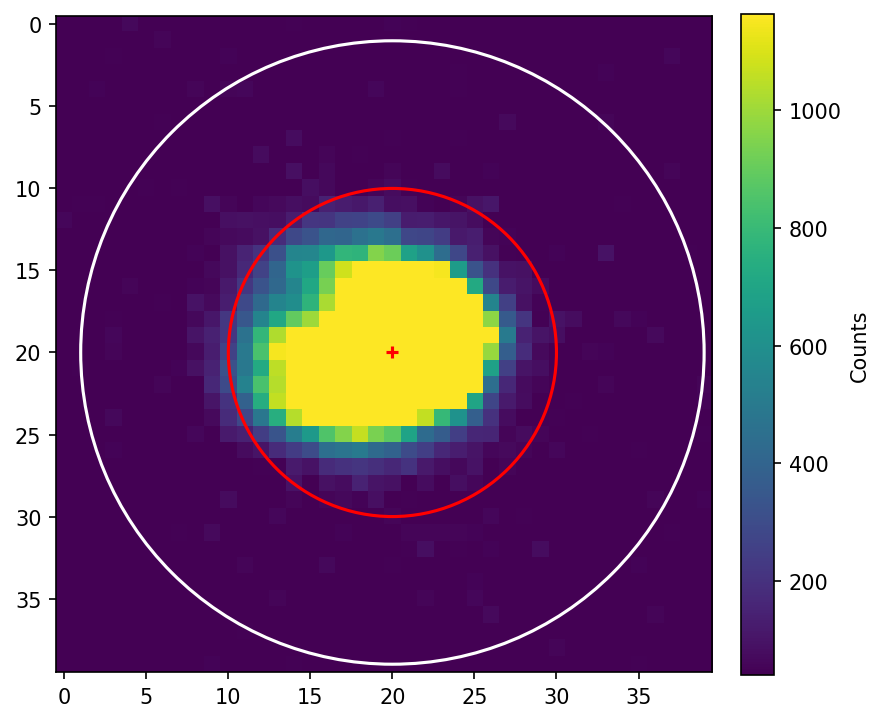

In [9]:
%matplotlib inline
positions = np.transpose((20, 20))
aperture = CircularAperture(positions, r=10)
outer_annulus =  CircularAperture(positions, r=19)

# create figure object
plt.figure(dpi=150, figsize=(6,6))

# plot the image
im = plt.imshow(centered_stars[1], 
                vmin=low,vmax=high)
                #norm=mpl.colors.LogNorm(),
                #origin='lower',cmap='magma')


# colorbar and aestheticcs
plt.colorbar(im,
             fraction=0.046, 
             pad=0.04,
             label='Counts')
plt.scatter(20, 20, marker='+', color='red')
aperture.plot(color='red', lw=1.5, alpha=1)
outer_annulus.plot(color='white', lw=1.5, alpha=1)
plt.tight_layout()
plt.savefig("Aperture_Example.png")

In [11]:
total_flux = [] 
std = [] #an array that holds the flux of each star across each transit image
aperture = []
annulus = []

center_x = 20
center_y = 20
radius = 6
outer_annulus = 19

for i in range(0,57):
    tot_star_flux, aperture_vals, annulus_vals  = star_flux(center_x, center_y, centered_stars[i,:,:],10)
    total_std =  std_star_flux(center_x, center_y, centered_stars[i,:,:],10)
    total_flux.append(tot_star_flux)
    std.append(total_std)
    aperture.append(aperture_vals)
    annulus.append(annulus_vals)


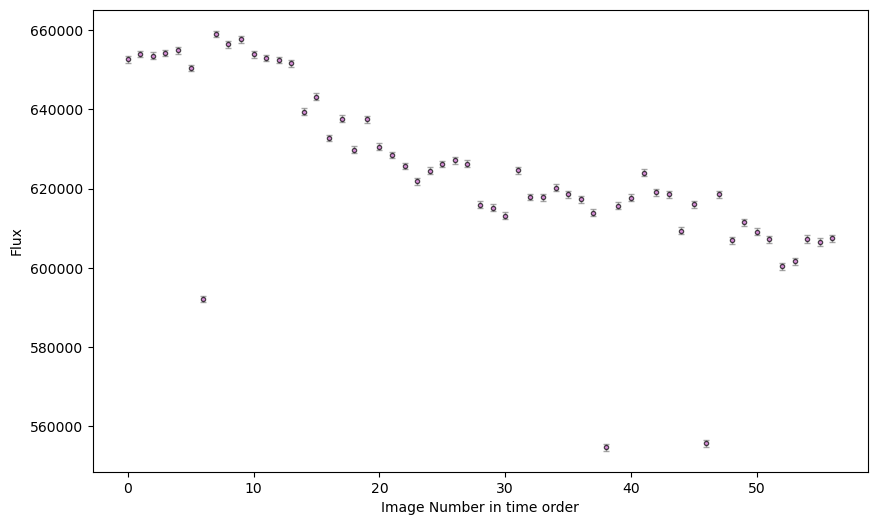

In [26]:
time=np.arange(0,57,1)
datastyle = dict(mec='k', linestyle='none',
                 ecolor='grey',marker = '.', 
                 mfc='violet', label='data',
                 alpha=0.7,elinewidth=1,capsize=2)

%matplotlib inline
plt.figure(figsize=(10,6))

plt.errorbar(time, total_flux, std, **datastyle)
plt.xlabel("Image Number in time order")
plt.ylabel('Flux')
plt.savefig('Flux_Transit.png')
plt.show()

In [27]:
centered_ref = getdata('zoomed_images_ref.fits')

In [28]:
total_flux_ref = [] #an array that holds the flux of each star across each transit image
std_ref = []
aperture_ref = []
annulus_ref = []

center_x = 20
center_y = 20
radius = 6
outer_annulus = 19

for i in range(0,57):
    tot_star_flux, aperture_vals, annulus_vals  = star_flux(center_x, center_y, centered_ref[i,:,:], 10)
    total_std =  std_star_flux(center_x, center_y, centered_ref[i,:,:],10)
    total_flux_ref.append(tot_star_flux)
    std_ref.append(total_std)
    aperture_ref.append(aperture_vals)
    annulus_ref.append(annulus_vals)


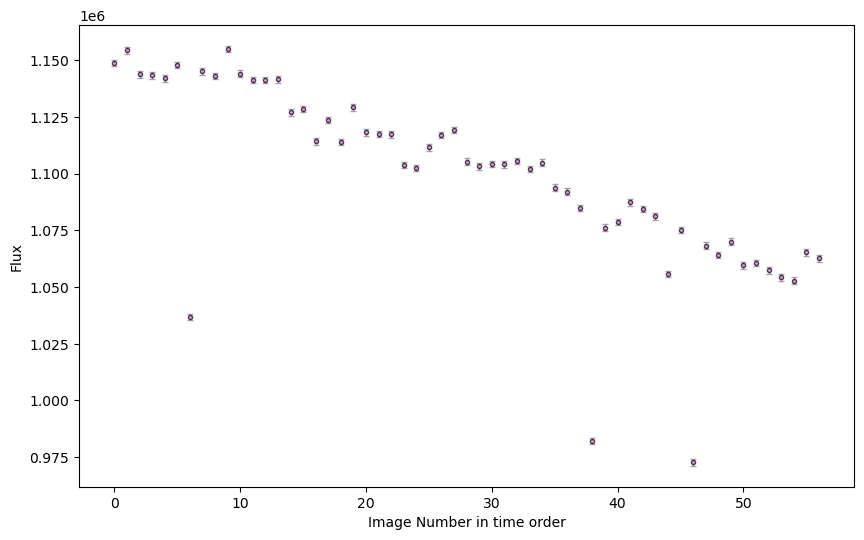

In [41]:
time=np.arange(0,57,1)
datastyle = dict(mec='k', linestyle='none',
                 ecolor='grey',marker = '.', 
                 mfc='violet', label='data',
                 alpha=0.7,elinewidth=1,capsize=2)

%matplotlib inline
plt.figure(figsize=(10,6))

plt.errorbar(time, total_flux_ref, std_ref, **datastyle)
plt.xlabel("Image Number in time order")
plt.ylabel('Flux')
plt.savefig('Flux_Ref.png')
plt.show()

In [30]:
centered_ref2 = getdata('zoomed_images_ref2.fits')

In [32]:
total_flux_ref2 = [] #an array that holds the flux of each star across each transit image
std_ref2 = []
aperture_ref2 = []
annulus_ref2 = []

center_x = 20
center_y = 20
radius = 6
outer_annulus = 19

for i in range(0,57):
    tot_star_flux, aperture_vals, annulus_vals  = star_flux(center_x, center_y, centered_ref2[i,:,:], 10)
    total_std = std_star_flux(center_x, center_y, centered_ref2[i,:,:], 10)
    std_ref2.append(total_std)
    total_flux_ref2.append(tot_star_flux)
    aperture_ref2.append(aperture_vals)
    annulus_ref2.append(annulus_vals)


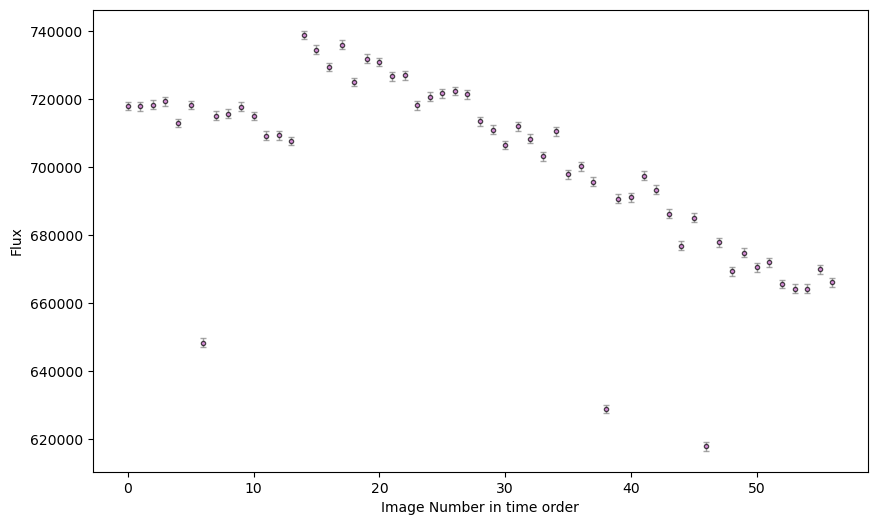

In [42]:
time=np.arange(0,57,1)
datastyle = dict(mec='k', linestyle='none',
                 ecolor='grey',marker = '.', 
                 mfc='violet', label='data',
                 alpha=0.7,elinewidth=1,capsize=2)

%matplotlib inline
plt.figure(figsize=(10,6))

plt.errorbar(time, total_flux_ref2, std_ref2, **datastyle)
plt.xlabel("Image Number in time order")
plt.ylabel('Flux')
plt.savefig('Flux_Ref2.png')
plt.show()

In [39]:
average_ref_flux = []
for i in range(len(total_flux_ref)):
    average_ref_flux.append((total_flux_ref[i]+total_flux_ref2[i])/2)
    
err_avg = []
for i in range(len(total_flux_ref)):
    error = np.sqrt(std_ref[i]**2 + std_ref2[i]**2)/2
    err_avg.append(error)
    
light_curve_ref = []
for i in range(len(total_flux_ref)):
    light_curve_ref.append(total_flux[i]/average_ref_flux[i])
    
err = []

for i in range(len(total_flux_ref)):
    error = np.sqrt(std[i]**2/average_ref_flux[i]**2 + err_avg[i]**2/average_ref_flux[i]**4)
    err.append(error)


In [44]:
light_curve_ref[light_curve_ref >= 0.7]

TypeError: '>=' not supported between instances of 'list' and 'float'

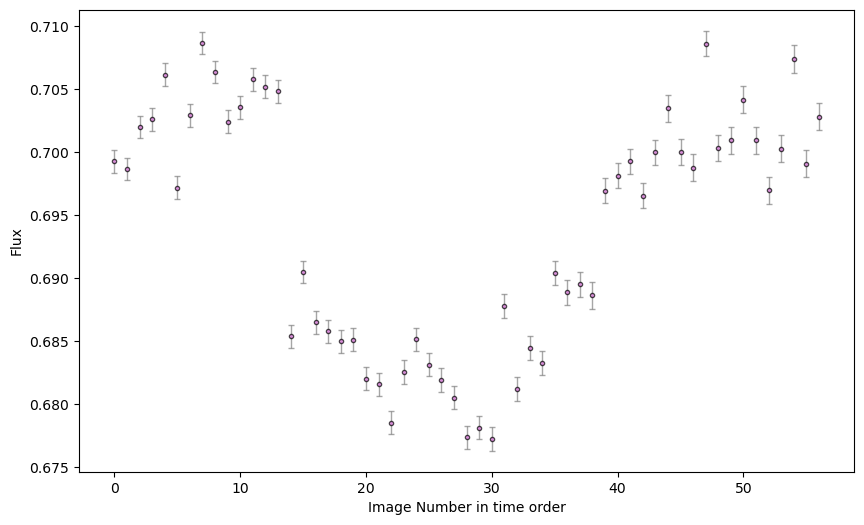

In [43]:
time=np.arange(0,57,1)

datastyle = dict(mec='k', linestyle='none',
                 ecolor='grey',marker = '.', 
                 mfc='violet', label='data',
                 alpha=0.7,elinewidth=1,capsize=2)

%matplotlib inline
plt.figure(figsize=(10,6))

plt.errorbar(time, light_curve_ref, err, **datastyle)
plt.xlabel("Image Number in time order")
plt.ylabel('Flux')
plt.savefig('TRANSIT.png')
plt.show()